In [ ]:
%pip install datasets
%pip install --upgrade datasets fsspec
%pip install bertopic

In [2]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import plotly.express as px
import string

from hdbscan import HDBSCAN
from umap import UMAP
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from bertopic import BERTopic

import matplotlib.pyplot as plt
from collections import defaultdict

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('stopwords')

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Setup e Pre-processing

## Download Dataset

In [4]:
def assign_class(row):
    votes = {
        "Normal": row["label_0"],
        "Offensive": row["label_1"],
        "Hate": row["label_2"]
    }
    max_vote = max(votes.values())
    candidates = [cls for cls, v in votes.items() if v == max_vote]

    # Priority: Hate > Offensive > Normal
    if "Hate" in candidates:
        return "Hate"
    elif "Offensive" in candidates:
        return "Offensive"
    else:
        return "Normal"


df = pd.read_csv("v2.tsv", sep="\t")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df[df["language"] == 1].copy()
df["class"] = df.apply(assign_class, axis=1)
df = df[df["class"] == "Hate"]

texts_list= list(df["text"])

/tmp/ipython-input-2298091116.py:19: DtypeWarning: Columns (0,4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("v2.tsv", sep="\t")


In [ ]:
# @title Creazione degli Embeddings
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embeddings = model.encode(texts_list, show_progress_bar=True)

In [6]:
embeddings.shape

(1617, 768)

## Dimensionality Reduction

In [16]:
from sklearn.decomposition import PCA

# Denoising embedding trhough PCA
pca = PCA(n_components=50, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

#umap_model = UMAP(n_components=5, min_dist=0.0, metric="cosine", random_state=42)
umap_model = UMAP(
    n_neighbors=50, # Default is 15, maube this could also go up
    n_components=10,  # Same
    metric="cosine",
    min_dist=0.0,
    random_state=42
)

# Topic Modeling con BERTTopic

## Rimozione delle stopwords dagi articoli


In [9]:
# Nel calcoo degli embedding contestuali rimuovere le stopwords non da alcun vantaggio, anzi potrebbe peggiorare le performance.
# Tuttavia BERTTopic utilizza internamente una variante di TF-IDF ragion per cui utilizziamo gli embeddings generati dal testo originale ma passiamo il testo "pulito" al modello
# N.B. Senza questo accorgimento il modello fa molta fatica ed individua solo 2 topics con rappresentati tutte stopword

stop_words = set(stopwords.words("english"))
processed_texts = [None] * texts_list.__len__()

for i in range(texts_list.__len__()):
    # Remove stop words
    processed_texts[i] = " ".join([word for word in word_tokenize(texts_list[i]) if word.lower() not in stop_words and word not in string.punctuation])

## Istanziazione del modello e creazione dei topic

In [ ]:
#min_samples should reduce some noise
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=3, metric="euclidean",cluster_selection_method="eom").fit(reduced_embeddings)
topic_model = BERTopic(embedding_model = model, umap_model = umap_model, hdbscan_model = hdbscan_model, verbose=True).fit(processed_texts, embeddings)

In [18]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,122,-1_china_kill_fuck_https,"[china, kill, fuck, https, co, israel, muslims...",[Flu virus 'pandemic potential found China ask...
1,0,436,0_trump_fuck_russian_co,"[trump, fuck, russian, co, https, biden, trait...","[’ still fuck Donald Trump, 2020 Year Review D..."
2,1,257,1_gay_kill_gays_hate,"[gay, kill, gays, hate, hell, people, go, gend...",[hate `` n't hate gay people n't agree lifesty...
3,2,225,2_football_hate_league_fucking,"[football, hate, league, fucking, fuck, basket...","[Oh fuck Like fuck Fuck league man, Fuck footb..."
4,3,163,3_muslim_muslims_terrorist_hindu,"[muslim, muslims, terrorist, hindu, india, co,...",[Shaheen Bagh terrorist Kapil Gujjar joins BJP...
5,4,146,4_turkey_kurds_turks_https,"[turkey, kurds, turks, https, co, turkeyinvade...",[Turkey n't hate kurds hate pkk Also turkey bo...
6,5,82,5_hero_iranian_soleimani_برای_سرباز,"[hero, iranian, soleimani, برای_سرباز, terrori...",[Zionists cowardly assassinated Iranian Genera...
7,6,77,6_african_africans_black_south,"[african, africans, black, south, killed, http...","[really hate african time, hate get fck Africa..."
8,7,73,7_religion_church_god_kill,"[religion, church, god, kill, christian, catho...",[Leave church alone want end well first resist...
9,8,36,8_league_legends_game_rocket,"[league, legends, game, rocket, hate, fucking,...",[league trash hope get heart attack playing le...


## Cluster analysis

In [19]:
topic_model.visualize_topics()

In [20]:
topics_over_time = topic_model.topics_over_time(texts_list, list(df["date"]))
topic_model.visualize_topics_over_time(topics_over_time)

2025-09-24 14:17:51,383 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 1567) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 
1567it [00:14, 107.68it/s]


In [24]:
fig = topic_model.visualize_documents(
  texts_list,
  reduced_embeddings = reduced_embeddings,
  width = 1200,
  hide_annotations = False
)
fig.update_layout(font = dict(size = 16))
topic_model.visualize_barchart()

In [25]:
# year and quarter
df["year"] = df["date"].dt.year
df["quarter"] = df["date"].dt.quarter
df["year_quarter"] = df["year"].astype(str) + "-Q" + df["quarter"].astype(str)
df["topic"] = topic_model.topics_

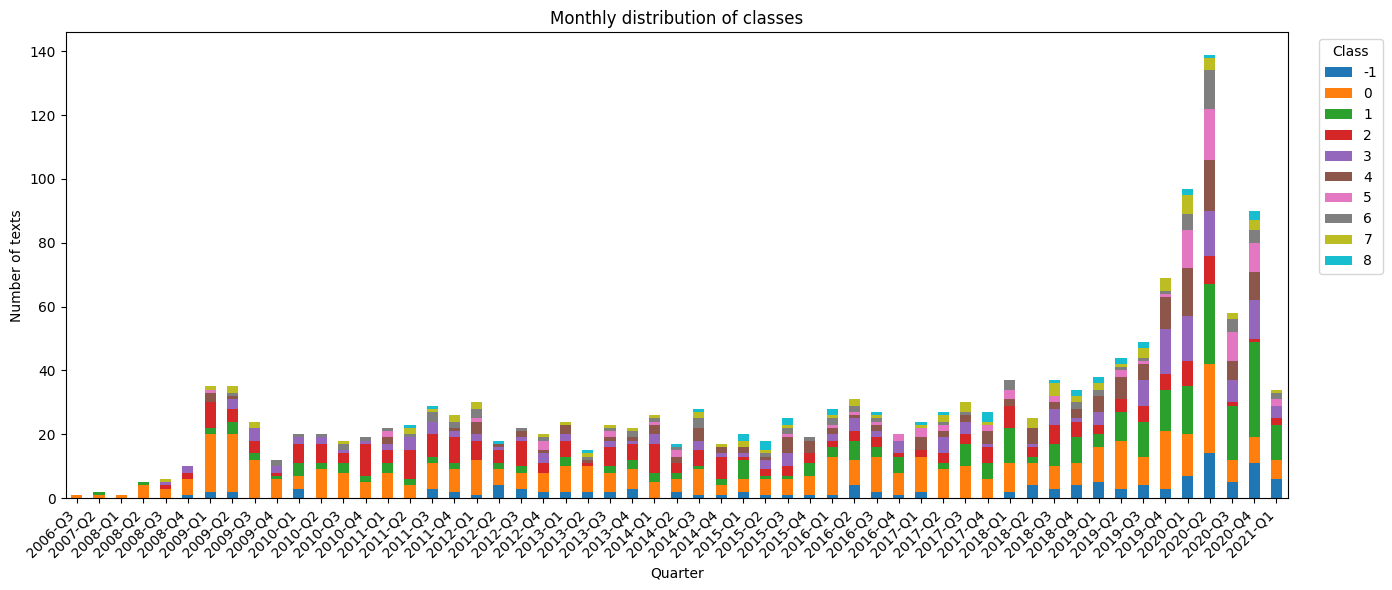

In [26]:
import matplotlib.pyplot as plt

monthly_counts = df.groupby(["year_quarter", "topic"]).size().unstack(fill_value=0).sort_index()
monthly_counts.plot(kind="bar", stacked=True, figsize=(14, 6))

plt.title("Monthly distribution of classes")
plt.xlabel("Quarter")
plt.ylabel("Number of texts")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [22]:
topic_model.visualize_heatmap(n_clusters = 2)